In [ ]:
import sys
sys.path.insert(0, "../..")

import jax
import jax.numpy as jnp

import jax.scipy
import jax.scipy.special

from tqdm import tqdm
from functools import partial

import module.samplers
import module.hamiltonians
import module.wavefunctions

import flax.linen as nn

import optax
import numpy as np
from matplotlib import pyplot as plt

import run.utils
run.utils.path = "../../plots/"

In [3]:
key = jax.random.PRNGKey(0)

NameError: name 'jax' is not defined

In [4]:
def getLine(phi, theta, r_max = 10):
    r = jnp.linspace(-r_max, r_max, num = 2000)
    x = jnp.cos(phi)*jnp.sin(theta) * r
    y = jnp.sin(phi)*jnp.sin(theta) * r
    z = jnp.cos(theta) * r

    return r, jnp.stack((x,y,z), axis = 1)

## 1. Introduction

In this notebook, we try to demonstrate an LCAO Ansatz combined with a Neural Network to find the ground state of the $\mathrm{H}_2^{+}$ molecule.
The LCAO Ansatz enforces the Kato-cusp condition, which is difficult to model by a Neural Network (singularity of the gradient). The deviations from the LCAO Ansatz are represented by a Neural Network.

Given the nucliei positions $\vec{R_i} $, the potential Energy is:

$$
V = - \sum_{i} \frac{k_i}{|\vec{r} - \vec{R_i}|}
$$

with $k_i = \frac{Z_i e^2}{4 \pi \epsilon_0}$

The solution to the single-nucleus problem is known:

$$
\Phi_i = e^{-\frac{m}{\hbar^2}k_i |\vec{r} - \vec{R_i}|} 
$$

notably satisfying the cusp condition:

$$
Z_k = -\frac{a_0}{2 n} \frac{dn}{dr} \quad\text{for} \lim r \to 0
$$

with $n = |\Psi|^2$.

The resulting Ansatz is thus:

$$
\Psi = \sum_{i} \alpha_i \Phi_i(\vec{r}) + e^{NN(\vec{r})}
$$

and $NN$ is a $C^2$-smooth Neural Network.

Remark: $\hbar = m  = 1$ and $e^2 = 4\pi\epsilon_0$ will be set.

### 1.1 Defining the Potential Energy

In [4]:
dist = 2.1095

R = jnp.array([[dist/2,0,0],[-dist/2,0,0]])     # nuclei positions
k = jnp.array([1.,1.])                          # potential energy coefficients

In [5]:
def calc_E_nuc():
    acc = 0
    for i in range(len(R)):
        for j in range(i + 1, len(R)):
            d = jnp.sqrt(jnp.sum((R[i] - R[j])**2))
            acc += k[i] * k[j] / d


    return acc

E_nuc = calc_E_nuc()

(-5.0, 1.0)

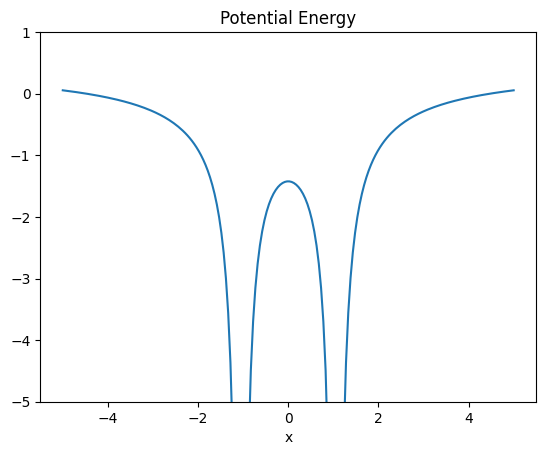

In [6]:

#
# The potential energy function depending on the coordinates
#
def potential(x):
    x = jnp.expand_dims(x, axis = 1)
    r = jnp.expand_dims(R,  axis = 0)
    d = jnp.sqrt(jnp.sum((x - r)**2, axis = 2))
    return - jnp.sum(k/d ,axis = 1) + E_nuc


# the hamiltonian
hamiltonian = module.hamiltonians.Particles(masses = [1], potential = potential)

xs = jnp.linspace(-5, 5, 200)
pos = jnp.array([xs,xs*0,xs*0])
ys = potential(jnp.swapaxes(pos, 0, 1))
plt.plot(xs, ys)
plt.title("Potential Energy")
plt.xlabel("x")
plt.ylim(-5, 1)

# run.utils.save_plot("The potential of the H2+ ion. The ionic distance is 2")

### 1.2 Defining the Wavefunction

In [ ]:
## netket.nn.log_cosh

class NN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(15, name="dense1", bias_init=jax.random.normal)(x)
        x = jnp.log(jnp.cosh(x))
        x = nn.Dense(15, name="dense2", bias_init=jax.random.normal)(x)
        x = jnp.log(jnp.cosh(x))
        x = nn.Dense(15, name="dense3", bias_init=jax.random.normal)(x)
        x = jnp.log(jnp.cosh(x))
        x = nn.Dense(1, name="dense4", bias_init=jax.random.normal)(x)
        x = jnp.log(jnp.cosh(x))
        return -jnp.squeeze(x)

In [ ]:
class Ansatz(module.wavefunctions.Wavefunction):
    def __init__(self):
        super().__init__(input_shape = (3,))

        self.nn = NN()
        self.lcao = module.wavefunctions.LCAO(R, k)


    def init_param(self, key):
        nn_param = self.nn.init(key, jnp.empty((2,)))

        return nn_param

    def eval_nn(self, parameters, x):
        abs_z = jnp.abs(x[:, 0])                # molecular axis
        r = jnp.sqrt(x[:, 1]**2 + x[:, 2]**2)   # radial distance
        phi = jnp.arctan2(x[:, 2], x[:, 1])     # angle

        coord = jnp.stack((abs_z, r), axis = 1)

        return self.nn.apply(parameters, coord)

    
    def calc_logpsi(self, parameters, x):
        
        return self.lcao.calc_logpsi(jnp.array([1., 1.]), x) + self.eval_nn(self, parameters, x)

In [ ]:
ansatz = Ansatz()
key, _ = jax.random.split(key)
param = ansatz.init_param(key)

In [ ]:
param

ScopeParamShapeError: Initializer expected to generate shape (2, 15) but got shape (3, 15) instead for parameter "kernel" in "/dense1". (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.ScopeParamShapeError)

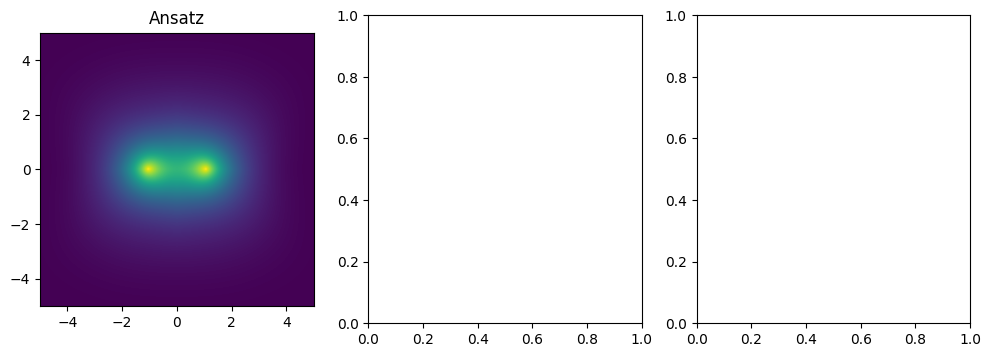

In [ ]:
f, axs = plt.subplots(1, 3, figsize = (12,4))

xs = jnp.linspace(-5, 5, num = 1000)
ys = jnp.linspace(-5, 5, num = 1000)
xss, yss = jnp.meshgrid(xs, ys)
im = jnp.stack((xss, yss, jnp.ones_like(xss) * 0), axis = 2)

res = ansatz.calc_psi(param, im.reshape(-1, 3)).reshape(xss.shape)
axs[0].imshow(res, extent = [-5, 5, -5, 5])
axs[0].set_title("Ansatz")

res = ansatz.eval_nn(param, im.reshape(-1, 3)).reshape(xss.shape)
axs[1].imshow(jnp.exp(res), extent = [-5, 5, -5, 5])
axs[1].set_title("Neural Network")


r, line = getLine(0, jnp.pi/2, r_max=2)
psi = ansatz.calc_logpsi(param, line)
psi_lcao = ansatz.lcao.calc_logpsi(jnp.array([1.,1.]), line)
nn_out = ansatz.eval_nn(param, line)

axs[2].plot(r, psi - jnp.max(psi), label = "Ansatz")
axs[2].plot(r, psi_lcao - jnp.max(psi_lcao), label = "LCAO")
axs[2].plot(r, nn_out, label = "NN output")

axs[2].set_title("Log Psi")
axs[2].legend()
axs[2].set_xlabel("x")

f.tight_layout()

# run.utils.save_plot("The combination of an LCAO Ansatz with a Neural Network added in the logarithm. Before Optimisation.")

### 1.3 Initialise Sampler

In [11]:
sampler = module.samplers.MCMC(ansatz, 0.5)

Acceptance Ratio: 0.56619996
Expected Energy: -0.5327468


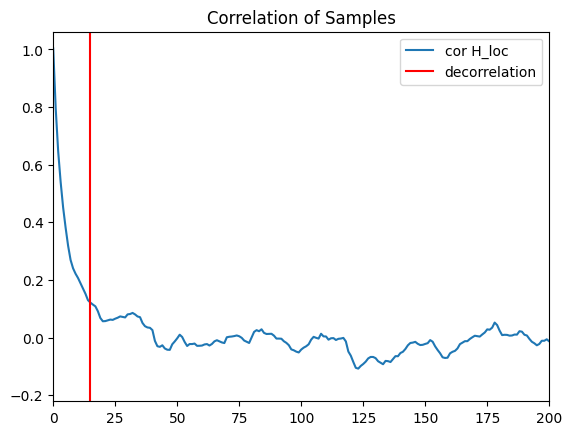

In [12]:
N = 10000
samples, ratio = sampler.sample(key, param, jax.random.normal(key, shape = (3,)), N)
H_loc = hamiltonian.calc_H_loc(ansatz, param, samples)
print("Acceptance Ratio:", ratio)
print("Expected Energy:", jnp.mean(H_loc))

plt.plot(jnp.correlate(H_loc-jnp.mean(H_loc), H_loc[0:2000]-jnp.mean(H_loc))/jnp.std(H_loc[0:2000])**2/2000, label = "cor H_loc")
plt.xlim(0,200)
plt.axvline(15, color = "r", label = "decorrelation")
plt.title("Correlation of Samples")
plt.legend()
plt.show()

In [13]:
subsampling = 20

In [14]:
def get_samples(N):
    """
    Returns decorrelated samples.
    """
    samples, ratio = sampler.sample(key, param, jax.random.normal(key, shape = (3,)), N*subsampling)
    return samples[0:-1:subsampling], ratio

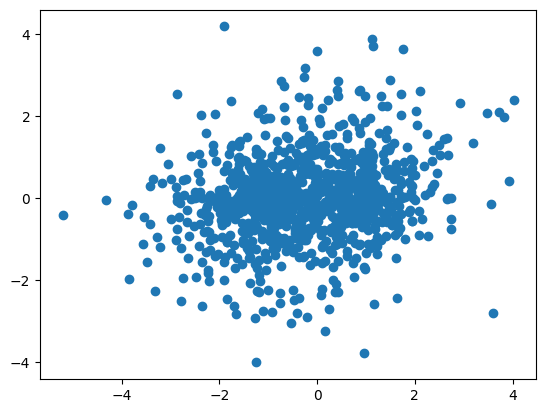

In [15]:
samples, ratio = get_samples(1000)
plt.scatter(samples[:, 0], samples[:, 1])

## 2. Energy Minimisation

In [21]:
@partial(jax.jit, static_argnames=['hamiltonian', 'orbital'])
def calc_grad_E(hamiltonian, orbital, parameters, samples):
    """
    Calculates the gradient of the energy and the energy itself on a batch of samples.
    """

    E_loc = hamiltonian.calc_H_loc(orbital, parameters, samples)
    E = jnp.mean(E_loc)
    dE = jnp.std(E_loc)
    grad_log = orbital.grad_logpsi(parameters, samples)

    m = lambda tree: 2*jnp.real(jnp.mean(jnp.swapaxes(jnp.swapaxes(tree, 0, -1) * (E_loc - E), 0, -1), axis = 0))

    return jax.tree_util.tree_map(m, grad_log), E, dE

In [45]:
stats = {"E":[], "dE":[], "ratio":[], "N_samples": []}
param = ansatz.init_param(key)

In [58]:
N = 8000
epoch = 100

# define
optimizer = optax.adam(learning_rate=0.005)

# initialise
optimizer_state = optimizer.init(param)

for i in tqdm(range(epoch)):
    key, _ = jax.random.split(key)
    samples, ratio = get_samples(N)
    grad, E, dE = calc_grad_E(hamiltonian, ansatz, param, samples)

    stats["E"].append(E)
    stats["dE"].append(dE)
    stats["ratio"].append(ratio)
    stats["N_samples"].append(N)
    
    updates, optimizer_state = optimizer.update(grad, optimizer_state, param)

    param = optax.apply_updates(param, updates)

100%|██████████| 100/100 [00:31<00:00,  3.16it/s]


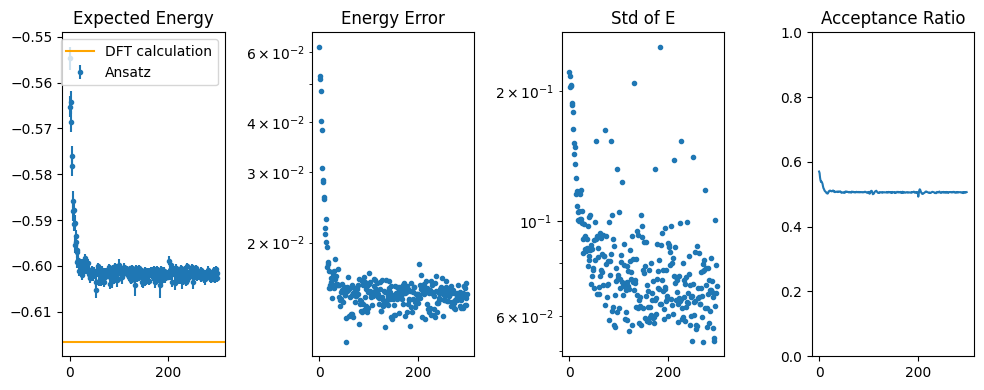

In [59]:
numpy_stats = {}
for key_ in stats.keys():
    numpy_stats[key_] = np.array(stats[key_])

f, ax = plt.subplots(1, 4, figsize = (10, 4))
i = np.arange(len(stats["E"]))

ax[0].errorbar(i, numpy_stats["E"], yerr = numpy_stats["dE"]/jnp.sqrt(numpy_stats["N_samples"]), fmt = ".", label = "Ansatz")
# ax[0].fill_between(i, numpy_stats["E"] - numpy_stats["dE"], numpy_stats["E"] + numpy_stats["dE"], alpha = 0.5)
ax[0].set_title("Expected Energy")
ax[0].axhline(-0.616515, label = "DFT calculation", color = "orange")
ax[0].legend(loc = "upper right")

ax[1].scatter(i, jnp.abs(numpy_stats["E"]+0.616515) , label = "error", marker = ".")
ax[1].set_title("Energy Error")
ax[1].set_yscale("log")

ax[2].scatter(i, stats["dE"], marker = ".")
ax[2].set_title("Std of E")
ax[2].set_yscale("log")

ax[3].plot(stats["ratio"])
ax[3].set_ylim(0,1)
ax[3].set_title("Acceptance Ratio")

f.tight_layout()

# run.utils.save_plot("The neural network improves the LCAO Ansatz in the H2+ molecule.")

Text(0.5, 1.0, 'Neural Network')

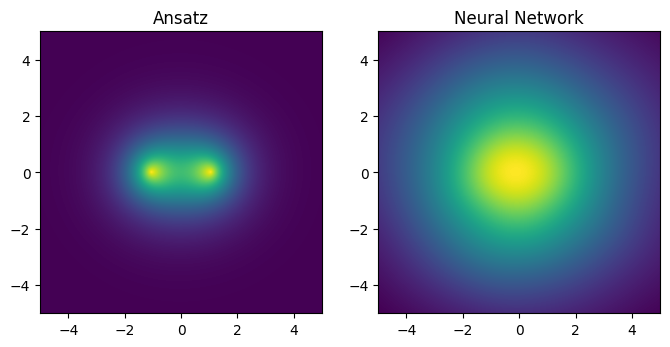

In [60]:
f, axs = plt.subplots(1, 2, figsize = (8,4))

xs = jnp.linspace(-5, 5, num = 1000)
ys = jnp.linspace(-5, 5, num = 1000)
xss, yss = jnp.meshgrid(xs, ys)
im = jnp.stack((xss, yss, jnp.ones_like(xss) * 0), axis = 2)

res = ansatz.calc_psi(param, im.reshape(-1, 3)).reshape(xss.shape)
axs[0].imshow(res, extent = [-5, 5, -5, 5])
axs[0].set_title("Ansatz")

res = ansatz.nn.apply(param["nn"], im.reshape(-1, 3)).reshape(xss.shape)
axs[1].imshow(jnp.exp(res), extent = [-5, 5, -5, 5])
axs[1].set_title("Neural Network")

# run.utils.save_plot("The optimised H2+ wavefunction.")

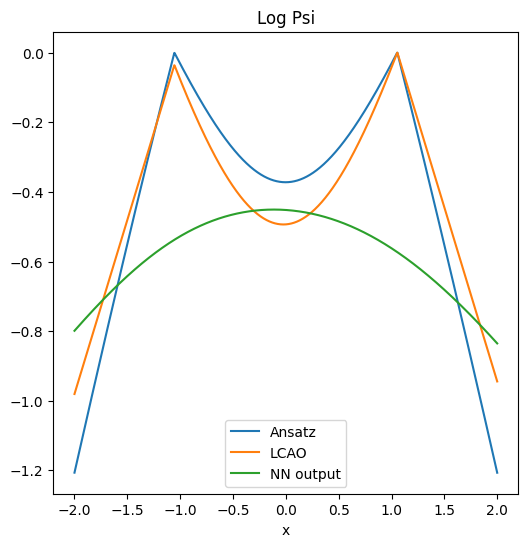

In [61]:
plt.figure(figsize=(6, 6))

r, line = getLine(0, jnp.pi/2, r_max=2)
psi = ansatz.calc_logpsi(param, line)
psi_lcao = ansatz.lcao.calc_logpsi(param["lcao"], line)
nn_out = ansatz.nn.apply(param["nn"], line)

plt.plot(r, psi - jnp.max(psi), label = "Ansatz")
plt.plot(r, psi_lcao - jnp.max(psi_lcao), label = "LCAO")
plt.plot(r, nn_out, label = "NN output")


plt.title("Log Psi")
plt.legend()
plt.xlabel("x")

run.utils.save_plot("The neural network corrects certain parts of the LCAO Ansatz. Especially in between the nuclei.")

In [62]:
N = 100000
samples, ratio = get_samples(N)
H_loc = hamiltonian.calc_H_loc(ansatz, param, samples)
print("Acceptance Ratio:", ratio)
print("Expected Energy:", jnp.mean(H_loc),"+/-", jnp.std(H_loc)/jnp.sqrt(N))
print("Std of Expected Energy:", jnp.std(H_loc))

Acceptance Ratio: 0.505441
Expected Energy: -0.6019707 +/- 0.0002648079
Std of Expected Energy: 0.0837396
